In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

/Users/Austin/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Load in the training set
training_set = pd.read_csv("data/mini_data/data/training_set/log_mini.csv")
training_set.hist_user_behavior_reason_start = training_set.hist_user_behavior_reason_start.astype('category')
training_set.hist_user_behavior_reason_end = training_set.hist_user_behavior_reason_end.astype('category')
training_set.context_type = training_set.context_type.astype('category')
training_set.date = training_set.date.apply(pd.to_datetime)

# Load in the track features
track_data = pd.read_pickle("data/pickles/track_features.pkl")

# Using skip_2 as the ground truth
training_set['skipped'] = (training_set.skip_2 | training_set.skip_1).astype('int32')
training_set = training_set.drop(columns=['skip_1','skip_2','skip_3','not_skipped'])
training_set.head()

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,skipped
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,0
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,0
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,0
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,0
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,0


In [3]:
track_data.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,...,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,...,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,...,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496
3,t_070a63a0-744a-434e-9913-a97b02926a29,175.399994,1951,99.665018,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,...,4,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.600006,1951,99.991764,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,...,4,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496


In [4]:
track_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50704 entries, 0 to 50703
Data columns (total 30 columns):
track_id                  50704 non-null object
duration                  50704 non-null float64
release_year              50704 non-null int64
us_popularity_estimate    50704 non-null float64
acousticness              50704 non-null float64
beat_strength             50704 non-null float64
bounciness                50704 non-null float64
danceability              50704 non-null float64
dyn_range_mean            50704 non-null float64
energy                    50704 non-null float64
flatness                  50704 non-null float64
instrumentalness          50704 non-null float64
key                       50704 non-null int64
liveness                  50704 non-null float64
loudness                  50704 non-null float64
mechanism                 50704 non-null float64
mode                      50704 non-null int32
organism                  50704 non-null float64
speechiness     

In [5]:
# Convert the columns to all be consistantly numeric
track_data.iloc[:,1:] = track_data.iloc[:,1:].astype('float32')
track_data.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950.0,99.975418,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,...,4.0,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950.0,99.969429,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,...,3.0,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951.0,99.602547,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,...,4.0,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496
3,t_070a63a0-744a-434e-9913-a97b02926a29,175.399994,1951.0,99.665016,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,...,4.0,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.600006,1951.0,99.991760,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,...,4.0,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496


In [6]:
# Join the two together
session_data = (
    training_set[['session_id','session_position','track_id_clean', 'skipped']]
    .merge(
        track_data,
        how='left',
        left_on=['track_id_clean'],
        right_on=['track_id']
    ).drop(columns='track_id_clean')
)
session_data.head()

,session_id,session_position,skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,0,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,180.066666,2018.0,99.968132,0.015848,0.438551,0.473455,...,4.0,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,0,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,236.796371,2018.0,99.896729,0.061811,0.654804,0.735661,...,4.0,0.337152,-0.713646,0.363718,0.310315,-0.042222,-0.383164,0.066357,-0.365308,0.157920
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,0,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,231.266663,2018.0,99.999977,0.354116,0.532155,0.540411,...,4.0,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,169.826675,2018.0,99.995041,0.769225,0.641756,0.729224,...,4.0,0.649420,-0.705116,0.317562,0.289141,-0.038920,-0.393358,0.092719,-0.364418,0.285603
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,0,t_64f3743c-f624-46bb-a579-0f3f9a07a123,210.545258,2018.0,99.998497,0.006602,0.732428,0.794881,...,4.0,0.652921,-0.868489,0.331280,0.210478,0.084740,-0.333287,-0.025706,-0.510350,0.182315


In [7]:
full_session_data = pd.concat((
    session_data,
    session_data.drop(columns=['track_id'])\
        .groupby('session_id')\
        .shift(1)\
        .rename(columns={c:f"previous_{c}" for c in session_data.columns})
), axis=1)
full_session_data.head()

,session_id,session_position,skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,...,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,0,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,180.066666,2018.0,99.968132,0.015848,0.438551,0.473455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,0,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,236.796371,2018.0,99.896729,0.061811,0.654804,0.735661,...,4.0,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,0,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,231.266663,2018.0,99.999977,0.354116,0.532155,0.540411,...,4.0,0.337152,-0.713646,0.363718,0.310315,-0.042222,-0.383164,0.066357,-0.365308,0.157920
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,169.826675,2018.0,99.995041,0.769225,0.641756,0.729224,...,4.0,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,0,t_64f3743c-f624-46bb-a579-0f3f9a07a123,210.545258,2018.0,99.998497,0.006602,0.732428,0.794881,...,4.0,0.649420,-0.705116,0.317562,0.289141,-0.038920,-0.393358,0.092719,-0.364418,0.285603


In [8]:
# full_session_data.to_pickle("data/pickles/current_and_previous_data.pkl")
full_data = pd.read_pickle("data/pickles/current_and_previous_data.pkl")

In [9]:
# Examine the columns
full_session_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167880 entries, 0 to 167879
Data columns (total 64 columns):
session_id                         167880 non-null object
session_position                   167880 non-null int64
skipped                            167880 non-null int32
track_id                           167880 non-null object
duration                           167880 non-null float32
release_year                       167880 non-null float32
us_popularity_estimate             167880 non-null float32
acousticness                       167880 non-null float32
beat_strength                      167880 non-null float32
bounciness                         167880 non-null float32
danceability                       167880 non-null float32
dyn_range_mean                     167880 non-null float32
energy                             167880 non-null float32
flatness                           167880 non-null float32
instrumentalness                   167880 non-null float32
key       

In [10]:
# Split the data:
# df -> X, y -> Train, Test, Val
X = full_session_data.drop(
    columns=["skipped","session_id","track_id"]
).fillna(-9999)
y = full_session_data.skipped
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=2
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=2
)
X.head(20)

,session_position,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
0,1,180.066666,2018.0,99.968132,0.015848,0.438551,0.473455,0.653119,7.660024,0.553465,...,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
1,2,236.796371,2018.0,99.896729,0.061811,0.654804,0.735661,0.877393,11.308750,0.726828,...,4.0,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
2,3,231.266663,2018.0,99.999977,0.354116,0.532155,0.540411,0.679719,8.065802,0.563009,...,4.0,0.337152,-0.713646,0.363718,0.310315,-0.042222,-0.383164,0.066357,-0.365308,0.157920
3,4,169.826675,2018.0,99.995041,0.769225,0.641756,0.729224,0.864881,11.287586,0.529484,...,4.0,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604
4,5,210.545258,2018.0,99.998497,0.006602,0.732428,0.794881,0.857778,12.181586,0.650057,...,4.0,0.649420,-0.705116,0.317562,0.289141,-0.038920,-0.393358,0.092719,-0.364418,0.285603
5,6,216.689484,2018.0,99.997604,0.098337,0.548632,0.658323,0.596480,10.416269,0.557129,...,4.0,0.652921,-0.868489,0.331280,0.210478,0.084740,-0.333287,-0.025706,-0.510350,0.182315
6,7,186.453323,2018.0,99.861565,0.449629,0.487708,0.608612,0.557520,9.834414,0.469350,...,5.0,0.661081,-0.817504,0.283297,0.387589,0.279636,-0.280334,0.117993,0.106159,0.311233
7,8,214.047348,2018.0,97.243820,0.017628,0.649367,0.682610,0.489405,9.900208,0.715155,...,4.0,0.109420,-0.748412,0.321976,0.237488,0.003480,-0.315287,0.032431,-0.464694,0.200836
8,9,218.260818,2018.0,99.998451,0.030127,0.818798,0.879947,0.964383,15.037571,0.555280,...,4.0,0.389913,-0.921928,0.359740,0.293674,0.115302,-0.274987,0.043193,-0.444351,0.211909
9,10,60.000000,2018.0,99.957436,0.332467,0.751500,0.843354,0.914082,14.457762,0.239318,...,4.0,0.338321,-0.744412,0.308700,0.230126,0.066493,-0.242549,0.025370,-0.403210,0.159350


In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
# Train a Logistic Regression model and score
scaler = StandardScaler().fit(X_train)
sX_train = scaler.transform(X_train)
sX_val = scaler.transform(X_val)
sX_test = scaler.transform(X_test)

log = LogisticRegressionCV(
    cv=3
).fit(
    sX_train,
    y_train
)

print("Log Train score: %s" % log.score(sX_train,y_train))
print("Log Val score:   %s" % log.score(sX_val,y_val))
print("Log Test score:  %s" % log.score(sX_test,y_test))

/Users/Austin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/Austin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/Austin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/Austin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/Austin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

Log Train score: 0.5405470807777147
Log Val score:   0.5340828710770261
Log Test score:  0.5351739337622111


/Users/Austin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [38]:
for pair in sorted(zip(X.columns,log.coef_[0]),key=lambda p: np.abs(p[1]),reverse=True):
    print("%30s | % .8f" % pair)

              previous_skipped |  9.27834912
             previous_loudness |  1.21767486
             previous_duration |  1.19599226
    previous_acoustic_vector_0 | -0.84087860
         previous_acousticness | -0.65913029
    previous_acoustic_vector_4 | -0.64312204
             previous_organism | -0.61573079
    previous_acoustic_vector_6 | -0.59333677
     previous_instrumentalness | -0.55985229
                  previous_key | -0.53944609
       previous_dyn_range_mean |  0.53556804
    previous_acoustic_vector_5 | -0.53409677
             previous_liveness | -0.51080398
     previous_session_position | -0.50114827
                 previous_mode | -0.49258185
             previous_flatness | -0.48889362
          previous_speechiness | -0.48819910
              previous_valence | -0.47960682
               previous_energy | -0.46082698
previous_us_popularity_estimate | -0.44132269
        previous_beat_strength | -0.43753214
         previous_danceability | -0.42490244
         

In [39]:
# Train a Random Forest model and score
rfc = RandomForestClassifier(
    n_estimators=100
).fit(
    X_train,
    y_train
)

print("RFC Train score: %s" % rfc.score(X_train,y_train))
print("RFC Val score:   %s" % rfc.score(X_val,y_val))
print("RFC Test score:  %s" % rfc.score(X_test,y_test))

RFC Train score: 0.9762757927459211
RFC Val score:   0.7082759390938536
RFC Test score:  0.7089289969025494


In [40]:
for pair in sorted(zip(X.columns,rfc.feature_importances_),key=lambda p:p[1],reverse=True):
    print("%30s | % .8f" % pair)

              previous_skipped |  0.19578811
     previous_session_position |  0.04016891
              session_position |  0.04012595
        us_popularity_estimate |  0.01683812
                      duration |  0.01556681
                      liveness |  0.01540399
                         tempo |  0.01506208
                      loudness |  0.01488127
                       valence |  0.01481640
                  acousticness |  0.01476371
             acoustic_vector_6 |  0.01472977
                   speechiness |  0.01469343
                      flatness |  0.01464076
             acoustic_vector_7 |  0.01455817
             previous_duration |  0.01451641
                     mechanism |  0.01446367
             acoustic_vector_1 |  0.01431869
                        energy |  0.01431116
             acoustic_vector_2 |  0.01420357
             acoustic_vector_4 |  0.01411375
previous_us_popularity_estimate |  0.01406615
             acoustic_vector_5 |  0.01406112
         

In [41]:
# Train a XGBoost model and score
xgb = XGBClassifier(
    n_estimators=100000
).fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train),(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=True
)

print("XGB Train score: %s" % xgb.score(X_train,y_train))
print("XGB Val score:   %s" % xgb.score(X_val,y_val))
print("XGB Test score:  %s" % xgb.score(X_test,y_test))

[0]	validation_0-error:0.270637	validation_1-error:0.273221
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.270637	validation_1-error:0.273221
[2]	validation_0-error:0.270637	validation_1-error:0.273221
[3]	validation_0-error:0.270637	validation_1-error:0.273221
[4]	validation_0-error:0.270637	validation_1-error:0.273221
[5]	validation_0-error:0.270637	validation_1-error:0.273221
[6]	validation_0-error:0.270637	validation_1-error:0.273221
[7]	validation_0-error:0.270637	validation_1-error:0.273221
[8]	validation_0-error:0.270897	validation_1-error:0.273259
[9]	validation_0-error:0.270637	validation_1-error:0.273221
[10]	validation_0-error:0.270897	validation_1-error:0.273259
Stopping. Best iteration:
[0]	validation_0-error:0.270637	validation_1-error:0.273221

XGB Train score: 0.729363476447977
XGB Val score:   0.7267786009456089
XGB Test score:  0.7

In [42]:
for pair in sorted(zip(X.columns,xgb.feature_importances_),key=lambda p:p[1],reverse=True):
    print("%30s | % .8f" % pair)

              previous_skipped |  0.95613986
              session_position |  0.00849634
        us_popularity_estimate |  0.00557356
             previous_duration |  0.00376234
                 beat_strength |  0.00364949
    previous_acoustic_vector_0 |  0.00303806
    previous_acoustic_vector_2 |  0.00290892
             previous_loudness |  0.00278162
                      loudness |  0.00249149
    previous_acoustic_vector_4 |  0.00240231
             previous_organism |  0.00236553
    previous_acoustic_vector_1 |  0.00233518
previous_us_popularity_estimate |  0.00221450
                      duration |  0.00184079
                  release_year |  0.00000000
                  acousticness |  0.00000000
                    bounciness |  0.00000000
                  danceability |  0.00000000
                dyn_range_mean |  0.00000000
                        energy |  0.00000000
                      flatness |  0.00000000
              instrumentalness |  0.00000000
         

In [11]:
# Train a LightGBM model and score
lgbm = LGBMClassifier(
    n_estimators=100000
).fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train),(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=True
)

print()
print("LGBM Train score: %s" % lgbm.score(X_train,y_train))
print("LGBM Val score:   %s" % lgbm.score(X_val,y_val))
print("LGBM Test score:  %s" % lgbm.score(X_test,y_test))

[1]	training's binary_logloss: 0.671588	valid_1's binary_logloss: 0.671957
Training until validation scores don't improve for 10 rounds
[2]	training's binary_logloss: 0.654525	valid_1's binary_logloss: 0.655176
[3]	training's binary_logloss: 0.640532	valid_1's binary_logloss: 0.641553
[4]	training's binary_logloss: 0.629001	valid_1's binary_logloss: 0.630376
[5]	training's binary_logloss: 0.61952	valid_1's binary_logloss: 0.621225
[6]	training's binary_logloss: 0.611686	valid_1's binary_logloss: 0.613657
[7]	training's binary_logloss: 0.605215	valid_1's binary_logloss: 0.60747
[8]	training's binary_logloss: 0.599839	valid_1's binary_logloss: 0.602332
[9]	training's binary_logloss: 0.595355	valid_1's binary_logloss: 0.598195
[10]	training's binary_logloss: 0.591654	valid_1's binary_logloss: 0.594802
[11]	training's binary_logloss: 0.58851	valid_1's binary_logloss: 0.592004
[12]	training's binary_logloss: 0.585867	valid_1's binary_logloss: 0.589705
[13]	training's binary_logloss: 0.58365

In [58]:
for pair in sorted(zip(X.columns,lgbm.feature_importances_),key=lambda p:p[1],reverse=True):
    print("%34s | % 5d" % pair)

            us_popularity_estimate |   121
                          duration |    72
   previous_us_popularity_estimate |    68
                  session_position |    64
                      release_year |    58
                      acousticness |    58
        previous_acoustic_vector_0 |    54
                 previous_duration |    52
                 previous_loudness |    52
                  previous_skipped |    49
        previous_acoustic_vector_2 |    47
                          loudness |    45
                             tempo |    45
                 acoustic_vector_1 |    45
                 acoustic_vector_5 |    45
                 acoustic_vector_6 |    45
         previous_instrumentalness |    44
        previous_acoustic_vector_5 |    43
                       speechiness |    42
                 previous_organism |    41
                 acoustic_vector_7 |    40
             previous_acousticness |    39
                          liveness |    38
           

In [42]:
lgbm_feature_importances = [[p[0], int(p[1])] for p in sorted(zip(X.columns,lgbm.feature_importances_),key=lambda p:p[1],reverse=True)]
lgbm_feature_importances[:5]

[['us_popularity_estimate', 121],
 ['duration', 72],
 ['previous_us_popularity_estimate', 68],
 ['session_position', 64],
 ['release_year', 58]]

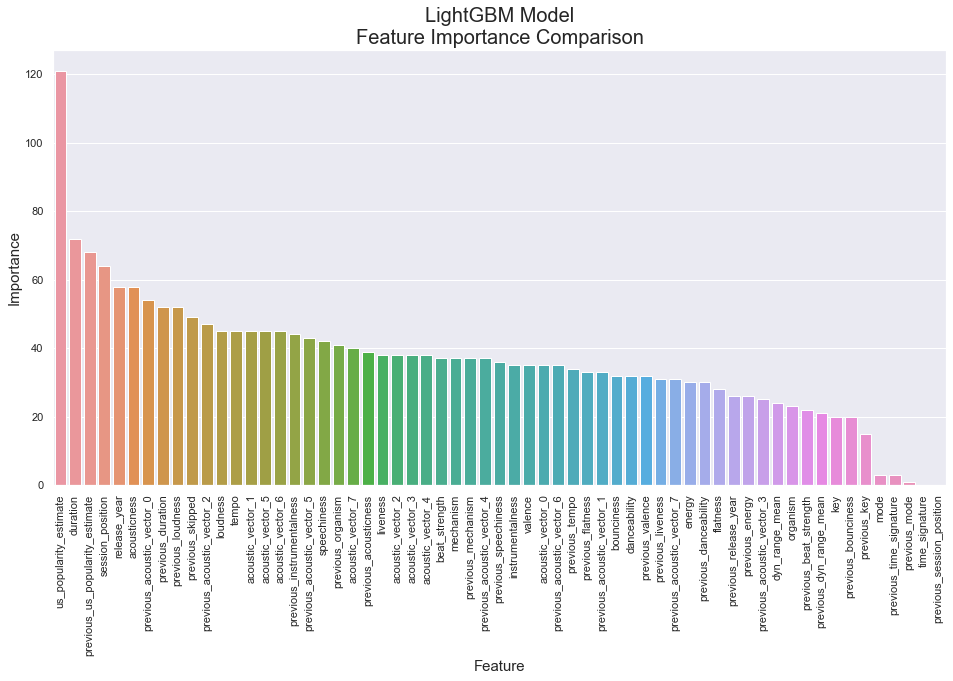

In [93]:
plt.figure(figsize=(16,8))
sns.barplot(
    "Feature",
    "Importance",
    data=pd.DataFrame(lgbm_feature_importances,columns=['Feature','Importance'])
)
plt.title(
    "LightGBM Model\nFeature Importance Comparison",
    fontsize=20
)
plt.xlabel(
    "Feature",
    fontsize=15
)
plt.ylabel(
    "Importance",
    fontsize=15
)
plt.xticks(rotation=90)
plt.savefig("images/lgbm_feature_importance.png")

***

In [13]:
from sklearn.metrics import confusion_matrix

In [ ]:
print("Logistic Regression Confusion Matrix")
print(confusion_matrix(
    y_test,
    log.predict(X_test)
) / sum(y_test.shape))

In [ ]:
print("Random Forest Confusion Matrix")
print(confusion_matrix(
    y_test,
    rfc.predict(X_test)
) / sum(y_test.shape))

In [ ]:
print("XGBoost Confusion Matrix")
print(confusion_matrix(
    y_test,
    xgb.predict(X_test)
) / sum(y_test.shape))

In [16]:
print("LightGBM Confusion Matrix")
print(confusion_matrix(
    y_test,
    lgbm.predict(X_test)
) / sum(y_test.shape))

LightGBM Confusion Matrix
[[0.35912557 0.12336193]
 [0.14849893 0.36901358]]


***

Save out the `LightGBM` model

In [143]:
# # Save out the model
# with open("lgbm_model_0.73TestAcc.pkl","wb") as f:
#     pickle.dump(lgbm,f)

In [17]:
# Load in the model
with open("lgbm_model_0.73TestAcc.pkl","rb") as f:
    lgbm = pickle.load(f)

***

In [77]:
from sklearn.metrics import accuracy_score

In [123]:
def predict_proba(X):
    predictions = (
        log.predict_proba(scaler.transform(X))[:,1] +
        rfc.predict_proba(X)[:,1] +
        xgb.predict_proba(X)[:,1] +
        lgbm.predict_proba(X)[:,1]
    )
    return predictions / 4

def predict(X,threshold=0.5):
    return (predict_proba(X) > threshold).astype('float32')

def score(X,y):
    return accuracy_score(y,predict(X))

print("Ensemble Train Accuracy:  %.3f" % score(X_train,y_train))
print("Ensemble Val Accuracy:    %.3f" % score(X_val,y_val))
print("Ensemble Test Accuracy:   %.3f" % score(X_test,y_test))

Ensemble Train Accuracy:  0.866
Ensemble Val Accuracy:    0.724
Ensemble Test Accuracy:   0.725


In [128]:
ensamble_predictions = predict(X_test)

***

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [20]:
lgbm_preds = lgbm.predict(X_test)

print("LightGBM Test Precision Score: %.3f" % precision_score(y_test,lgbm_preds))
print("LightGBM Test Recall Score:    %.3f" % recall_score(y_test,lgbm_preds))
print("LightGBM Test F1 Score:        %.3f" % f1_score(y_test,lgbm_preds))

LightGBM Test Precision Score: 0.749
LightGBM Test Recall Score:    0.713
LightGBM Test F1 Score:        0.731


In [129]:
print("Ensemble Test Precision Score: %.3f" % precision_score(y_test,ensamble_predictions))
print("Ensemble Test Recall Score:    %.3f" % recall_score(y_test,ensamble_predictions))
print("Ensemble Test F1 Score:        %.3f" % f1_score(y_test,ensamble_predictions))

Ensemble Test Precision Score: 0.743
Ensemble Test Recall Score:    0.714
Ensemble Test F1 Score:        0.729


Let's look at the residuals for the best model (`LightGBM`) and see if we can find a cause

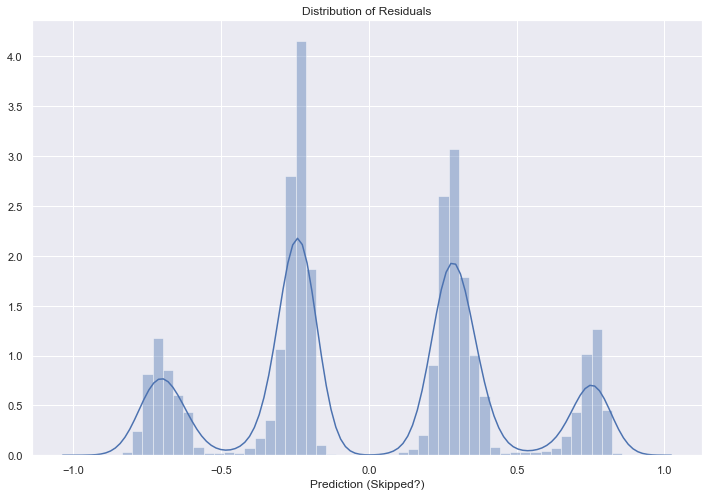

In [21]:
lgbm_probs = lgbm.predict_proba(X_test)[:,1]
lgmb_residuals = (lgbm_probs - y_test).sort_values()

plt.figure(figsize=(12,8))
sns.distplot(lgmb_residuals)
plt.title("Distribution of Residuals")
plt.xlabel("Prediction (Skipped?)")
plt.show()

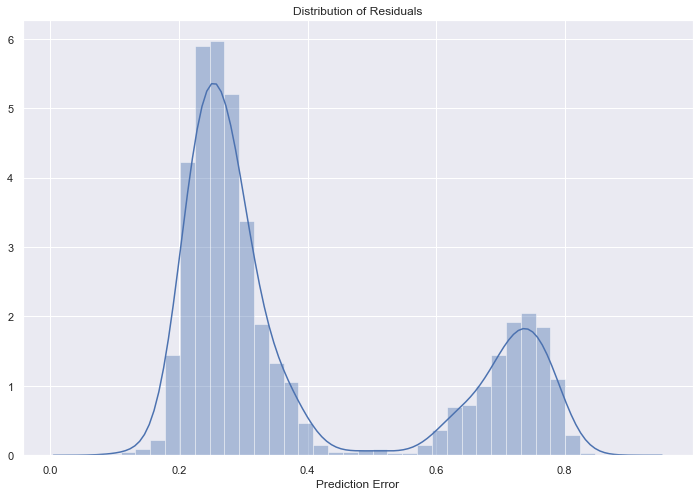

In [22]:
plt.figure(figsize=(12,8))
sns.distplot(np.abs(lgmb_residuals))
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error")
plt.show()

In [23]:
threshold = 0.6
print("Proportion of Residuals (Greater than %.2f):  %.4f" % (
    threshold,
    (np.abs(lgmb_residuals) > threshold).sum() / lgmb_residuals.count()
))

Proportion of Residuals (Greater than 0.60):  0.2633


In [24]:
target_residuals = np.abs(lgmb_residuals) > threshold
target_residuals = target_residuals.sort_index()
target_residuals.head()

5     False
9     False
14     True
15    False
21    False
Name: skipped, dtype: bool

In [25]:
X_test.sort_index().head()

,session_position,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
5,6,216.689484,2018.0,99.997604,0.098337,0.548632,0.658323,0.596480,10.416269,0.557129,...,4.0,0.652921,-0.868489,0.331280,0.210478,0.084740,-0.333287,-0.025706,-0.510350,0.182315
9,10,60.000000,2018.0,99.957436,0.332467,0.751500,0.843354,0.914082,14.457762,0.239318,...,4.0,0.338321,-0.744412,0.308700,0.230126,0.066493,-0.242549,0.025370,-0.403210,0.159350
14,15,228.661804,2018.0,99.971413,0.774773,0.617454,0.670036,0.823040,9.958458,0.447236,...,4.0,0.538387,-0.858347,0.317665,0.326257,0.103337,-0.287205,0.031015,-0.448952,0.202570
15,16,177.338776,2018.0,99.990738,0.205823,0.601301,0.689148,0.648763,10.634233,0.557770,...,4.0,0.413239,-0.797031,0.424720,0.342543,-0.023328,-0.315267,0.107823,-0.384532,0.181089
21,2,320.933319,1974.0,99.508057,0.000017,0.291298,0.251156,0.303636,5.012511,0.973996,...,4.0,0.237204,0.185752,0.275915,-0.242243,-0.384358,0.580225,0.107189,-0.256305,0.222407


In [26]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33576 entries, 159336 to 18534
Data columns (total 61 columns):
session_position                   33576 non-null int64
duration                           33576 non-null float32
release_year                       33576 non-null float32
us_popularity_estimate             33576 non-null float32
acousticness                       33576 non-null float32
beat_strength                      33576 non-null float32
bounciness                         33576 non-null float32
danceability                       33576 non-null float32
dyn_range_mean                     33576 non-null float32
energy                             33576 non-null float32
flatness                           33576 non-null float32
instrumentalness                   33576 non-null float32
key                                33576 non-null float32
liveness                           33576 non-null float32
loudness                           33576 non-null float32
mechanism         

Now we can use that information to perform error eda

In [48]:
# Sort the columns by lgbm's feature importance value
columns_to_compare, _ = zip(*sorted(zip(X.columns, lgbm.feature_importances_),key=lambda p:p[1],reverse=True))
columns_to_compare[:10]

('us_popularity_estimate',
 'duration',
 'previous_us_popularity_estimate',
 'session_position',
 'release_year',
 'acousticness',
 'previous_acoustic_vector_0',
 'previous_duration',
 'previous_loudness',
 'previous_skipped')

In [60]:
def plot(column):
    plt.figure(figsize=(8,4))
    sns.distplot(
        X_test[column][target_residuals],
        label="Residual > 0.6"
    )
    sns.distplot(
        X_test[column][~target_residuals],
        label="Residual < 0.6"
    )
    plt.title(f"Distribution of \"{column}\"\nw/ Residual Split")
    plt.show()
    return

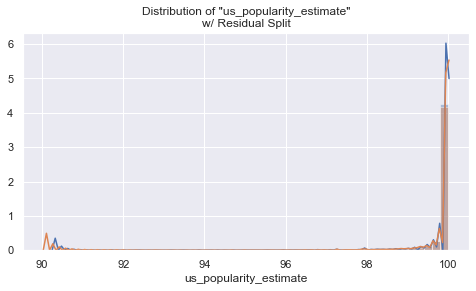

In [61]:
plot("us_popularity_estimate")

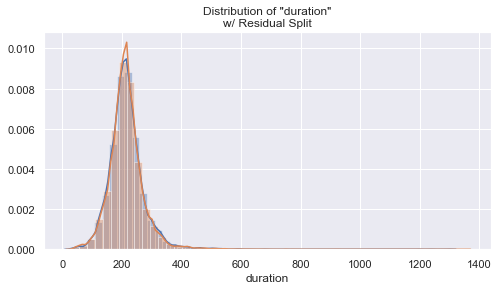

In [62]:
plot("duration")

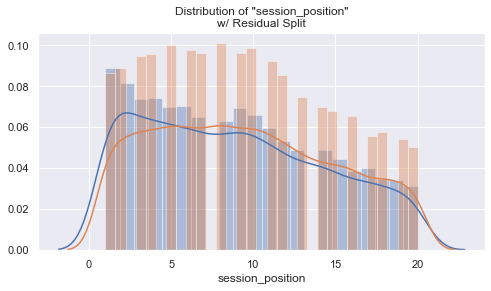

In [63]:
plot("session_position")

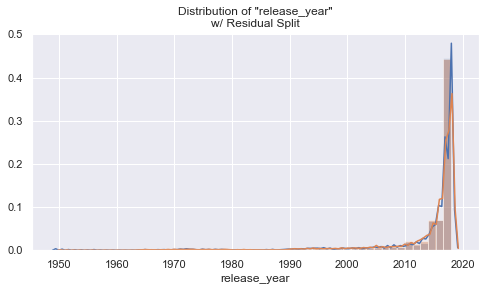

In [64]:
plot("release_year")

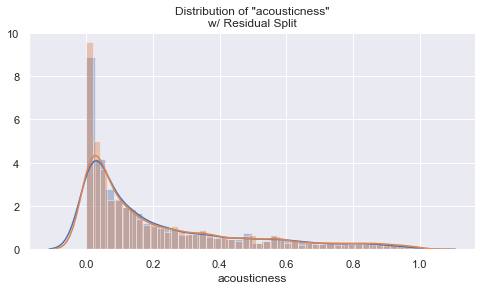

In [65]:
plot("acousticness")

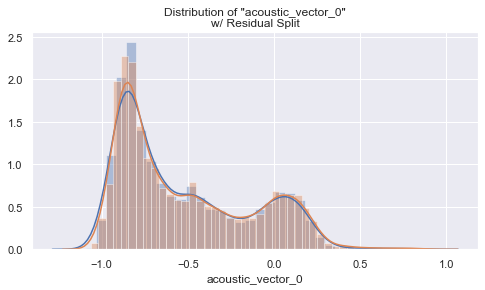

In [66]:
plot("acoustic_vector_0")

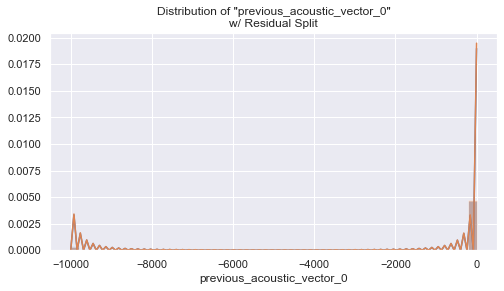

In [67]:
plot("previous_acoustic_vector_0")

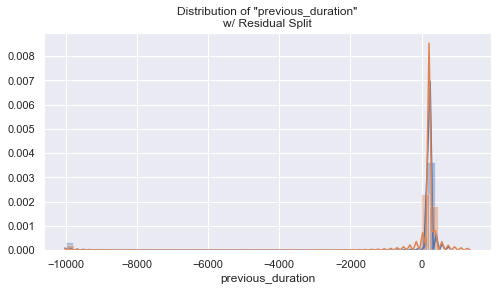

In [68]:
plot("previous_duration")

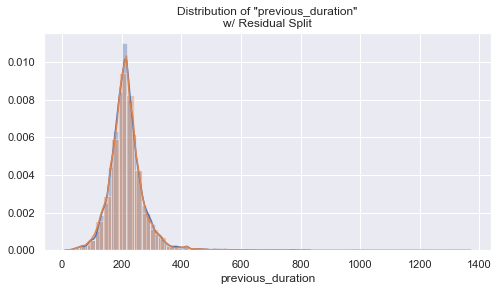

In [76]:
# The N/A value is making it hard to see the main distribution

plt.figure(figsize=(8,4))
sns.distplot(
    X_test["previous_duration"][target_residuals & (X_test["previous_duration"] > -2000)],
    label="Residual > 0.6"
)
sns.distplot(
    X_test["previous_duration"][~target_residuals & (X_test["previous_duration"] > -2000)],
    label="Residual < 0.6"
)
plt.title(f"Distribution of \"{ 'previous_duration' }\"\nw/ Residual Split")
plt.show()

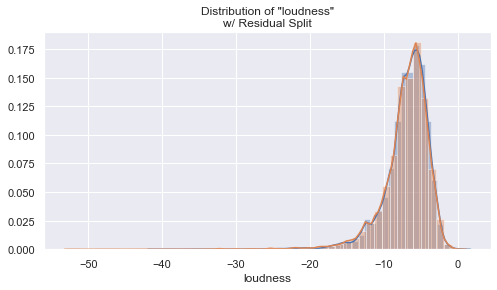

In [77]:
plot("loudness")

***

Now can we make some EDA charts to see what a session might look like...

In [95]:
full_session_data.head()

,session_id,session_position,skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,...,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,0,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,180.066666,2018.0,99.968132,0.015848,0.438551,0.473455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,0,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,236.796371,2018.0,99.896729,0.061811,0.654804,0.735661,...,4.0,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,0,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,231.266663,2018.0,99.999977,0.354116,0.532155,0.540411,...,4.0,0.337152,-0.713646,0.363718,0.310315,-0.042222,-0.383164,0.066357,-0.365308,0.157920
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,169.826675,2018.0,99.995041,0.769225,0.641756,0.729224,...,4.0,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,0,t_64f3743c-f624-46bb-a579-0f3f9a07a123,210.545258,2018.0,99.998497,0.006602,0.732428,0.794881,...,4.0,0.649420,-0.705116,0.317562,0.289141,-0.038920,-0.393358,0.092719,-0.364418,0.285603


In [96]:
session_ids = full_session_data.session_id.unique()
session_ids.shape

(10000,)

In [ ]:
past_sessions = [
    "0_05eb4c83-e0bd-4e12-b65e-9ccd18b39ef9"
]

In [178]:
rid = np.random.choice(session_ids)
rid

'0_053b4d58-8ba0-487b-9484-cf2c821d4a37'

In [179]:
session = full_session_data[full_session_data.session_id == rid]
session

,session_id,session_position,skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,...,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
61204,0_053b4d58-8ba0-487b-9484-cf2c821d4a37,1,0,t_77b02acb-1b1f-4b36-b8fc-2c3e01892b9a,232.959137,2018.0,99.999977,0.023649,0.776539,0.806856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61205,0_053b4d58-8ba0-487b-9484-cf2c821d4a37,2,0,t_bacf06d3-9185-4183-84ea-ff0db51475ce,217.925354,2018.0,99.999985,0.058855,0.847690,0.858075,...,4.0,0.341744,-0.899932,0.328876,0.252109,0.133214,-0.286828,-0.000055,-0.491611,0.145450
61206,0_053b4d58-8ba0-487b-9484-cf2c821d4a37,3,0,t_77b02acb-1b1f-4b36-b8fc-2c3e01892b9a,232.959137,2018.0,99.999977,0.023649,0.776539,0.806856,...,4.0,0.349988,-0.779654,0.325653,0.262234,0.032855,-0.342434,0.017437,-0.442791,0.143839
61207,0_053b4d58-8ba0-487b-9484-cf2c821d4a37,4,0,t_6bb0fd06-c97a-4bed-a0c2-42608084fb1d,245.520004,2015.0,99.997437,0.124116,0.732014,0.742122,...,4.0,0.341744,-0.899932,0.328876,0.252109,0.133214,-0.286828,-0.000055,-0.491611,0.145450
61208,0_053b4d58-8ba0-487b-9484-cf2c821d4a37,5,0,t_dcac3910-2e67-43d5-a1ef-d63f391d5630,256.533325,2015.0,99.999603,0.232989,0.499790,0.477896,...,4.0,0.394193,-0.765390,0.375487,0.299901,-0.007495,-0.288883,0.071188,-0.425114,0.161511
61209,0_053b4d58-8ba0-487b-9484-cf2c821d4a37,6,0,t_02d1fe3d-2c14-47f4-a325-7872a5fe350c,268.186676,2017.0,99.999321,0.057594,0.519908,0.560033,...,4.0,0.309436,-0.710463,0.442261,0.290319,-0.061645,-0.270744,0.078919,-0.217346,0.233856
61210,0_053b4d58-8ba0-487b-9484-cf2c821d4a37,7,0,t_c42b5e2e-a149-4063-b941-7cfdad1e6882,213.132065,2017.0,99.999802,0.030560,0.563023,0.627963,...,4.0,0.230659,-0.838938,0.289243,0.202228,0.139210,-0.278056,-0.032169,-0.461011,0.221800
61211,0_053b4d58-8ba0-487b-9484-cf2c821d4a37,8,0,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,231.266663,2018.0,99.999977,0.354116,0.532155,0.540411,...,4.0,0.363177,-0.821870,0.318286,0.212128,0.110378,-0.286620,-0.029366,-0.394517,0.178024
61212,0_053b4d58-8ba0-487b-9484-cf2c821d4a37,9,0,t_6ebb2f2f-0b60-415a-a865-18d9dab3c899,211.149841,2016.0,99.991890,0.685027,0.650655,0.655962,...,4.0,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604
61213,0_053b4d58-8ba0-487b-9484-cf2c821d4a37,10,0,t_21d8d90a-49f3-43f1-aea9-003ef442f58d,237.573334,2016.0,99.995316,0.128678,0.633469,0.656754,...,4.0,0.626207,-0.693427,0.202025,0.225365,0.140503,-0.225132,-0.033362,-0.344185,0.066532


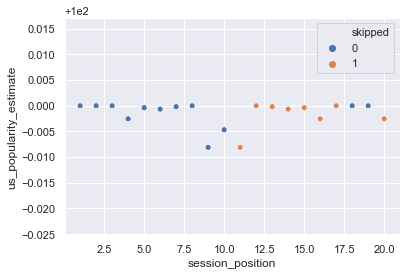

In [180]:
sns.scatterplot(
    session.session_position,
    session.us_popularity_estimate,
    hue=session.skipped
)

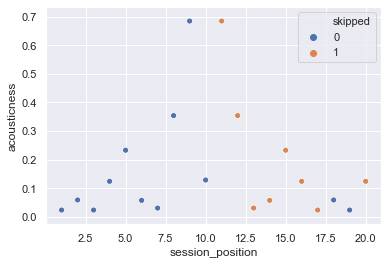

In [181]:
sns.scatterplot(
    session.session_position,
    session.acousticness,
    hue=session.skipped
)

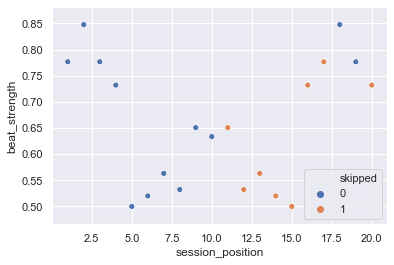

In [182]:
sns.scatterplot(
    session.session_position,
    session.beat_strength,
    hue=session.skipped
)

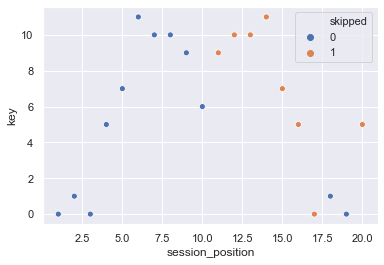

In [183]:
sns.scatterplot(
    session.session_position,
    session.key,
    hue=session.skipped
)

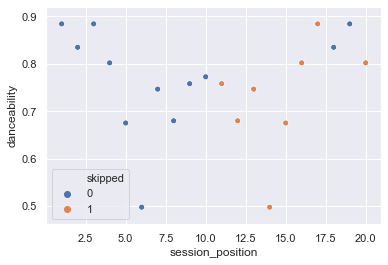

In [184]:
sns.scatterplot(
    session.session_position,
    session.danceability,
    hue=session.skipped
)

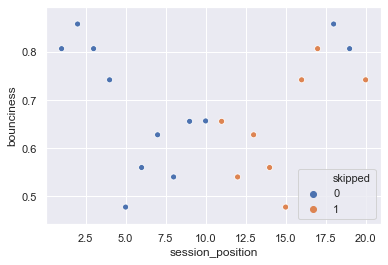

In [185]:
sns.scatterplot(
    session.session_position,
    session.bounciness,
    hue=session.skipped
)

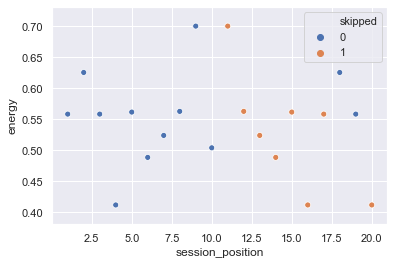

In [186]:
sns.scatterplot(
    session.session_position,
    session.energy,
    hue=session.skipped
)

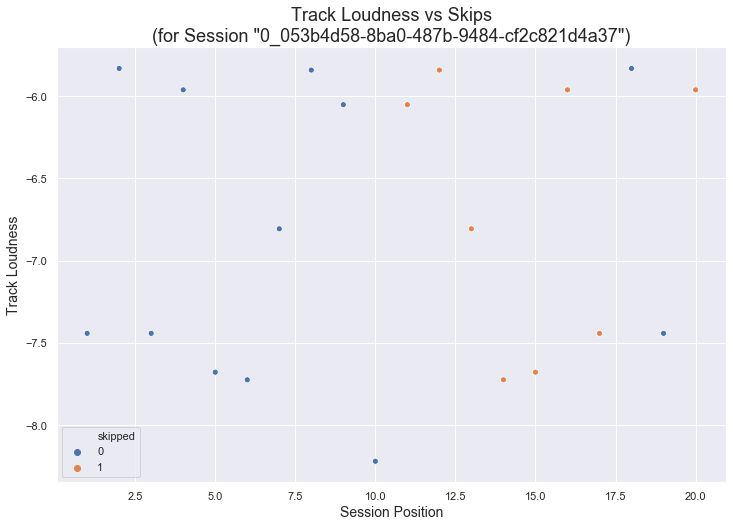

In [187]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    session.session_position,
    session.loudness,
    hue=session.skipped
)
plt.title(
    f"Track Loudness vs Skips\n(for Session \"{rid}\")",
    fontsize=18
)
plt.xlabel(
    "Session Position",
    fontsize=14
)
plt.ylabel(
    "Track Loudness",
    fontsize=14
)
# plt.savefig(f"images/session_eda/session_{rid}_loudness.png")
plt.show()

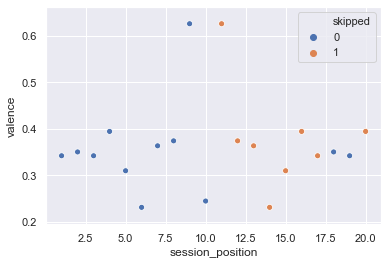

In [188]:
sns.scatterplot(
    session.session_position,
    session.valence,
    hue=session.skipped
)

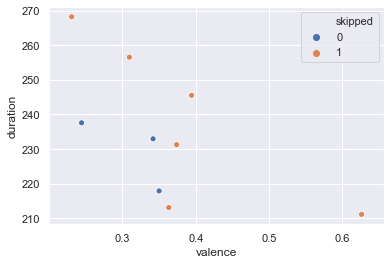

In [189]:
sns.scatterplot(
    session.valence,
    session.duration,
    hue=session.skipped
)